<a href="https://colab.research.google.com/github/fipaniagua/IIC3697-Deep-Learning/blob/develop/CNN%20Inception%20with%20Keras/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1: Redes Neuronales Convolucionales (CNNs)
Francisco Paniagua

## Parte 1: GoogleNet Inception V1

En esta sección se implementara la arquitectura de googleNet inception mediante el uso de la librerias Keras.
Especificamente se usara la arquitectura descrita en la siguiente tabla:


![texto alternativo](https://miro.medium.com/max/1400/1*lRN3h9a_qJdT6NIy0VOu3Q.png)

In [2]:
#modulos de keras 
import keras
from keras.models import Model
from keras.regularizers import l2
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, concatenate, AveragePooling2D

Using TensorFlow backend.


### Actividad 1


In [24]:
Inputs = Input(shape=(224,224,3))

x = Conv2D(64, (7, 7), strides=(2,2), padding='same', activation='relu', use_bias=False, name='Conv2d_1a_7x7_conv')(Inputs)
print(x.shape) #Para analizar el tamaño del tensor x. Entrega: (batch_size="None", dimension1, dimension2, dimension3 (dada por la cantidad de filtros))
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='MaxPool_2a_3x3')(x)

model = Model(Inputs, x, name="Inception model 1")
model.summary()

(None, 112, 112, 64)
Model: "Inception model 1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
Conv2d_1a_7x7_conv (Conv2D)  (None, 112, 112, 64)      9408      
_________________________________________________________________
MaxPool_2a_3x3 (MaxPooling2D (None, 56, 56, 64)        0         
Total params: 9,408
Trainable params: 9,408
Non-trainable params: 0
_________________________________________________________________


Como se puede apreciar las salida del modelo "Inception model 1" de la capa Maxpool_2a_3x3 es de (56,56,64) lo cual concuerda con la segunda fila de la tabla de la arquitectura de googleNet


### Actividad 2

Ahora procederemos a agregar las siguientes capas al modelo:
1. Convolución de 64 filtros, con ventana de 1x1 y stride de 1. Sin bias.
1. Convolución de 192 filtros, con ventana de 3x3 y stride de 1. Sin bias.
1. MaxPooling de ventana de 3x3 y stride de 2


In [25]:
l2a = Conv2D(64, (1, 1), strides=(1,1), padding='same', activation='relu', use_bias=False, name='Conv2d_2a_1x1')(x) 
l2b = Conv2D(192, (3, 3), strides=(1,1), padding='same', activation='relu', use_bias=False, name='Conv2d_2b_3x3')(l2a)
l2c = MaxPooling2D((3,3), strides=(2,2), padding="same", name = "MaxPool_2c_3x3")(l2b)
print(l2c.shape)

(None, 28, 28, 192)


La arquitectura de GoogleNet usa continuamente convoluciones de 1x1 con stride de 1, debido a que si estas convoluciones no exitieran la complejidad de computo seria demasiado grande. A continuación se pueden ver 2 tablas, con las cuales podemos comparar el computo que se necesita para realizar dos convoluciones (una de 3x3 y otra de 5x5) si se antepone o no una convolucion de 1x1


> Sin convoluciones previas de 1x1:

Input size| operation type | filter size | output size | operations required (output size x filter size)
--- | --- | --- | --- |---
28x28x192 | Conv2d 5x5 (32 filters)| 5x5x192 | 28x28x32 | 120.422.400  
28x28x192 | Conc2d 3x3 (128 filters) | 3x3x192 | 28x28x128 | 173.408.256
    | |  | |  293 millones

> Con convoluciones previas de 1x1

Input size| operation type | filter size | output size | operations required (output size x filter size)
--- | --- | --- | --- |---
28x28x192 | Conv2d 1x1 (96 filters) | 1x1x192 | 28x28x96 | 14.450.688
28x28x192 | Conv2d 1x1 (16 filters) | 1x1x192 | 28x28x16 | 2.408.448
28x28x96  | Conv2d 3x3 (128 filters) | 3x3x96 | 28x28x128 | 86.704.128
28x28x16  | Conv2d 5x5 (32 filters)  | 5x5x16 | 28x28x32 | 10.035.200  
 | | | | 112 millones

En este ejemplo podemos apreciar como el uso de las convoluciones de 1x1 permiten reducir la complejidad de 293 millones a 112 millones de operaciones


### Actividad 3

Normalmente las redes neuronales convolucionales van aplicando filtros (convoluciones) consecutivamente, que permiten ir aumentando la profundidad de la red. En cada una de estas capas es necesario ir eliguiendo el tamaño de los filtros. El modulo de incepcion que creo GoogleNet permiter no tener que escoger un tamaño de filtro en particular, y darle la oportunidad a la red de usar en cada capa diferentes tamaños de filtros (1x1, 3x3, 5x5, 3x3 max pooling). Esto seria computacionalmente muy dificil si no se agregaran los filtro de 1x1 antes de cada convolucion, tal como se explico en la sección anterior.

Para poder juntar el output de de cada uno de los filtro,  cada convolucion mantiene las dimensiones del "alto" y "largo" del mismo tamaño que la capa anteruir (para esto se usan paddings), luego se concatenan agrupando el resultado de todas las convoluciones atraves del eje de la "profundidad" (el tamaño de la profundida varia segun cuantos filtros distintos del mismo tamaña se quieran utilizar)

![Imagen convolucion](https://miro.medium.com/max/751/1*AU4SaMgvVYFREakegt-R4A.png)

### Actividad 4

In [0]:
def generate_inception_layer(input_tensor, size_1x1, reduce_3x3_size, size_3x3, reduce_5x5_size, size_5x5, pool_proj_size, module_name, regularization = 0 ):
    branch_0 = Conv2D(size_1x1, (1,1), strides=(1,1), padding="same",
                      activation="relu", name = "{0}_branch_0_a_1x1".format(module_name), 
                      kernel_regularizer = l2(regularization))(input_tensor)
    branch_1a = Conv2D(reduce_3x3_size, (1,1), strides=(1,1), padding="same",
                       activation="relu", name="{0}_branch_1a_1x1".format(module_name),
                       kernel_regularizer = l2(regularization))(input_tensor)
    branch_1b = Conv2D(size_3x3, (3,3), strides=(1,1), padding="same", 
                       activation="relu", name="{0}_branch_1b_3x3".format(module_name),
                       kernel_regularizer = l2(regularization))(branch_1a)
    branch_2a = Conv2D(reduce_5x5_size, (1,1), strides=(1,1), padding="same",
                       activation="relu", name="{0}_branch_2a_1x1".format(module_name),
                       kernel_regularizer = l2(regularization))(input_tensor)
    branch_2b = Conv2D(size_5x5, (5,5), strides=(1,1), padding="same", 
                       activation="relu", name="{0}_branch_2b_5x5".format(module_name),
                       kernel_regularizer = l2(regularization))(branch_2a)
    branch_3a = MaxPooling2D((3,3),strides=(1,1),padding="same", name="{0}_branch_1c_maxpool".format(module_name))(input_tensor)
    branch_3b = Conv2D(pool_proj_size, (1,1), strides=(1,1), padding="same", activation="relu", name="{0}_branch_2c_1x1".format(module_name))(branch_3a)
    concat_layer = concatenate([branch_0, branch_1b, branch_2b, branch_3b], axis=3, name="{0}_concatenated_layer".format(module_name))
    return concat_layer


In [26]:
l3a = generate_inception_layer(l2c, 64, 96, 128, 16, 32, 32, "3a")
l3a.shape

TensorShape([None, 28, 28, 256])

Como podemos notar la funcion de modulo esta entregando las dimensiones correctas, ya que despues de la capa 2c viene un modulo *inception* que deveria entregar un output de 28x28x256 (fila 5 de la tabla de la arquitectura de GoogleNet)

### Actividad 5

En esta sección implementaremos la red completa previa a la capa de *AveragePool*.


<img src="https://i.kym-cdn.com/photos/images/facebook/000/531/557/a88.jpg" alt="drawing" width="500"/>


In [0]:
l3b = generate_inception_layer(l3a, 128, 128, 192, 32, 96, 64, "3b")
l3c = MaxPooling2D((3,3), strides=(2,2), padding="same", name="Max_pool_3c_3x3")(l3b)
l4a = generate_inception_layer(l3c, 192, 96, 208, 16, 48, 64, "4a")
l4b = generate_inception_layer(l4a, 160, 112, 224, 24, 64, 64, "4b")
l4c = generate_inception_layer(l4b, 128, 128, 256, 24, 64, 64, "4c")
l4d = generate_inception_layer(l4c, 112, 144, 288, 32, 64, 64, "4d")
l4e = generate_inception_layer(l4d, 256, 160, 320, 32, 128, 128, "4e")
l4f = MaxPooling2D((3,3), strides=(2,2), padding="same", name="Max_pool_4f_3x3")(l4e)
l5a = generate_inception_layer(l4f, 256, 160, 320, 32, 128, 128, "5a")
l5b = generate_inception_layer(l5a, 384, 192, 384, 48, 128, 128, "5b")

La manera mas sensilla de revisar si nuestra implementacion de las capas tiene las dimensiones correctas es verificar que la ultima capa "*Inception 5b*" entrege un output de 7x7x1024 (fila 5 de la tabla de la arquitectura)

In [0]:
l5b.shape

TensorShape([None, 7, 7, 1024])

### Actividad 6

Finalmente agregaremos las ultimas capas e instanciaremos el modelo.

In [0]:
lavgpool = AveragePooling2D((7,7), strides=(1,1), name="Avarage_pool_7x7")(l5b)
print(lavgpool.shape)
ldrop = Dropout(0.4)(lavgpool)
lflat = Flatten()(ldrop)
llinear = Dense(1000, use_bias=False, name="linear")(lflat)
lfinal = Activation("softmax")(llinear)

(None, 1, 1, 1024)


In [0]:
final_model = Model(Inputs, lfinal, name="inceptionNet")
final_model.summary()

Model: "inceptionNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_7x7_conv (Conv2D)     (None, 112, 112, 64) 9408        input_8[0][0]                    
__________________________________________________________________________________________________
MaxPool_2a_3x3 (MaxPooling2D)   (None, 56, 56, 64)   0           Conv2d_1a_7x7_conv[0][0]         
__________________________________________________________________________________________________
Conv2d_2a_1x1 (Conv2D)          (None, 56, 56, 64)   4096        MaxPool_2a_3x3[0][0]             
_______________________________________________________________________________________

## Parte 2.1: CIFAR-10


### Actividad 7


En esta seccion se comparara la arquitectura desarrollada (GoogLeNet Inception v1) con otras dos arquitecturas (AlexNet y ResNet) que tambien han competido en el set de datos ImageNet.


<img src="https://miro.medium.com/max/1400/1*DBXf6dzNB78QPHGDofHA4Q.png" alt="drawing" width="380"/>


A pesar de que a simple vista pareciera que la unica razón que explicara el mejoramiento del performance es la cantidad de capas. Cada uno de los modelos desarrollaron una tecnologia particular que les permitio destacarse en la competencia del año que ganaron.

Un resumen simplificado de estas caracteristicas es el siguiente:


> __AlexNet (2012)__
Con una arquitectura parecida al ganador del año anterior   (LeNet), pero mas profunda, con mas filtros por capa y activaciones RELU despues de cada capa. Se entreno de forma paralelisada, lo cual permitio entrenar la gran cantidad de parametros que tiene.


> __GoogLeNet (2014)__
Primera red en alcanzar un puntaje parecido al de los humanos. Esta inspirada en LeNet, pero con un novedoso aproach (modulos inception). que permitio redcir notablemente la cantidad de parametros requeridos.


> __ResNet (2015)__
Introdujo una novedosa arquitectura con "saltos de conecciones". Esta arquitectura tiene bastante similitudes
con recientes elementos exitosos de las Redes Neuronales Recurrentes









A continuación se presenta un cuadro comparativo de las distintas arquitecturas


Nombre de la red | Profundidad | Cantidad de parametros | Error en ImageNet (Top-5)
--- | --- | --- | --- |
  AlexNet | 8| 62.378.344 | 16,4%
  GoogleNet | 22 | 6.997.232 | 6,67%
  Resnet (ILSVRC’15) | 152| 60.300.000 | 3.57%



#### GoogLeNet Inception for CIFAR-10

Debido a la relativa rapides de entrenamiento de la arquitectura de GoogLeNet y su buen desempeño, usaremos este modelo para enfrentar CIFAR-10 y CIFAR-100, devido a que nos permitirar entrenar el modelo varias veces en un tiempo mas rasonable y asi poder probar distintos hiper-parametros.

A continuacion crearemos una función, que nos permitiara generar un modelo con la arquitectura de googlenet inception. La funcionción iene el parametro **labels** que nos permite determinar el numero de salida de la ultima capa (para poder adaptar la arquitectura a CIFAR10 y CIFAR100). Tambien para ajustar el modelo se agrego el hiperparametro **regularization** que permite ajustar la penalisación que se le hace a los pesos del modelo en una regularizacion del tipo **L2**.

In [0]:
def generate_inception_model(name, learning_rate=1.0, rho=0.95, loss="categorical_crossentropy", labels=10, regularization = 0):
  Inputs = Input(shape=(32,32,3))
  x = Conv2D(64, (7, 7), strides=(2,2), padding='same', activation='relu', use_bias=False, name='Conv2d_1a_7x7_conv')(Inputs)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='MaxPool_2a_3x3')(x)
  l2a = Conv2D(64, (1, 1), strides=(1,1), padding='same', activation='relu', use_bias=False, name='Conv2d_2a_1x1')(x) 
  l2b = Conv2D(192, (3, 3), strides=(1,1), padding='same', activation='relu', use_bias=False, name='Conv2d_2b_3x3')(l2a)
  l2c = MaxPooling2D((3,3), strides=(2,2), padding="same", name = "MaxPool_2c_3x3")(l2b)
  l3a = generate_inception_layer(l2c, 64, 96, 128, 16, 32, 32, "3a", regularization= regularization)
  l3b = generate_inception_layer(l3a, 128, 128, 192, 32, 96, 64, "3b", regularization= regularization)
  l3c = MaxPooling2D((3,3), strides=(2,2), padding="same", name="Max_pool_3c_3x3")(l3b)
  l4a = generate_inception_layer(l3c, 192, 96, 208, 16, 48, 64, "4a", regularization= regularization)
  l4b = generate_inception_layer(l4a, 160, 112, 224, 24, 64, 64, "4b", regularization= regularization)
  l4c = generate_inception_layer(l4b, 128, 128, 256, 24, 64, 64, "4c", regularization= regularization)
  l4d = generate_inception_layer(l4c, 112, 144, 288, 32, 64, 64, "4d", regularization= regularization)
  l4e = generate_inception_layer(l4d, 256, 160, 320, 32, 128, 128, "4e")
  l4f = MaxPooling2D((3,3), strides=(2,2), padding="same", name="Max_pool_4f_3x3")(l4e)
  l5a = generate_inception_layer(l4f, 256, 160, 320, 32, 128, 128, "5a", regularization= regularization)
  l5b = generate_inception_layer(l5a, 384, 192, 384, 48, 128, 128, "5b", regularization= regularization)
  lavgpool = AveragePooling2D((1,1), strides=(1,1), name="Avarage_pool_7x7")(l5b)
  ldrop = Dropout(0.4)(lavgpool)
  lflat = Flatten()(ldrop)
  llinear = Dense(1000, use_bias=False, name="linear")(lflat)
  llinear2 = Dense(labels, use_bias=False, name="linear2")(llinear)
  lfinal = Activation("softmax")(llinear2)
  inceptionCifarNet = Model(Inputs, lfinal, name=name)
  #luego de crear la arquitectura compilamos el modelo
  opt = keras.optimizers.Adadelta(learning_rate=learning_rate, rho=rho)
  inceptionCifarNet.compile(loss='categorical_crossentropy',
                              optimizer=opt,
                              metrics=['accuracy'])
  return inceptionCifarNet


### Actividad 8

Para probar el modelo se usara el dataset CIFAR10, el cual consiste en imagenes de 32x32x3 y 10 clases distintas. El dataset contiene 60000 imagenes y se dividira de la siguiente forma:

set | cantidad de instancias | porcentaje relativo del total
--- | --- | --- |
train | 45000 | 75%
validation (hyperparameters tunning)| 5000 | 8,3333%
test |  10000 | 16,6666%

A continuación se muestran imagenes del dataset y sus respectivas etiquetas.

In [0]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

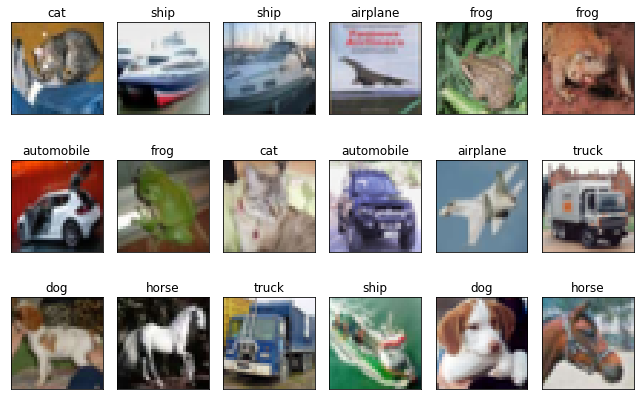

In [48]:
import matplotlib.pyplot as plt

labels_map = ["airplane", "automobile", "bird", "cat", "deer",
              "dog", "frog", "horse", "ship", "truck"] 

fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, sample_index in zip(axs.flat, list(range(18))):
    ax.imshow(x_test[sample_index], interpolation='none')
    ax.set_title(labels_map[y_test[sample_index][0]])

plt.tight_layout()
plt.show()

Luego creamos la division del *validation set* tomando un 10% del *training set*

In [49]:
from sklearn.model_selection import train_test_split

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

#split a validation set from the training set
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.1)
print("Train set shape:", x_train.shape)
print("Validation set shape", x_validation.shape)


Train set shape: (45000, 32, 32, 3)
Validation set shape (5000, 32, 32, 3)


### Actividad 9

Luego de entrenar los distintos modelos, es necesario guardar los pesos, para poder reutilizarlos luego de que la memoria de la sesion se borre. Para eso se guardara en una carpeta de Google Drive.

In [42]:
!pip install pyyaml h5py

In [43]:
import os
import tensorflow as tf
import keras
print(tf.version.VERSION)

2.2.0-rc4


In [0]:
os.mkdir("drive/My Drive/keras_trainig/10")
os.mkdir("drive/My Drive/keras_trainig/100")

Para facilitar la creacion de modelos con distintos parametros y distintos dataset (Para la seccion 2.2) Se creara la funcion run_model que permite:  

*   Generar el modelo
*   compilarlo con la funcion de perdida  **categorical_crossentropy**
*  Entrenar el modelos segun las **epocas** y el tamaño de **batch** indicado
* Guardar los pesos en Drive


In [0]:
def run_model(name, labels, epochs, batch_size, x_train, y_train, x_validation, y_validation, regularization = 0, verbose=2):
    print("training model with {0} epochs and {1} batch size".format(epochs, batch_size))
    checkpoint_path = "drive/My Drive/keras_trainig/{0}/cp_epochs={1}_batch={2}_{3}.ckpt".format(
                      labels, str(epochs), str(batch_size), regularization)
    model = generate_inception_model(name, labels=labels, regularization=regularization)
    history = model.fit(x_train, 
                        y_train, 
                        batch_size=batch_size,
                        epochs=epochs,
                        shuffle=True,
                        verbose=verbose,
                        validation_data = (x_validation, y_validation)
                        )  
    model.save_weights(checkpoint_path)
    return {"history":history, "model":model, 
            "path:":checkpoint_path, "epochs":epochs,
            "batch": batch_size}


En un comienzo partiremos probando entrenar con 30 epocas y un tamaño de batch de 32. No se usara regularización.

In [13]:
model_info_v1 = run_model("inception_cifar10_32_30", 10, 30, 32, x_train, y_train, x_validation, y_validation)

training model with 30 epochs and 32 batch size
Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 379s 8ms/step - loss: 2.2073 - accuracy: 0.1502 - val_loss: 2.1420 - val_accuracy: 0.2502
Epoch 2/30
45000/45000 [==============================] - 374s 8ms/step - loss: 1.7993 - accuracy: 0.3141 - val_loss: 3.5548 - val_accuracy: 0.1814
Epoch 3/30
45000/45000 [==============================] - 373s 8ms/step - loss: 1.5988 - accuracy: 0.4025 - val_loss: 1.5531 - val_accuracy: 0.4350
Epoch 4/30
45000/45000 [==============================] - 372s 8ms/step - loss: 1.4626 - accuracy: 0.4732 - val_loss: 1.3969 - val_accuracy: 0.5016
Epoch 5/30
45000/45000 [==============================] - 372s 8ms/step - loss: 1.3600 - accuracy: 0.5174 - val_loss: 1.6781 - val_accuracy: 0.4584
Epoch 6/30
45000/45000 [==============================] - 372s 8ms/step - loss: 1.2686 - accuracy: 0.5570 - val_loss: 1.2945 - val_accuracy: 0.5468
Epoch 7/30
4500

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_model_history(model_info):
  # Plot training & validation accuracy values
  plt.plot(model_info["history"].history['accuracy'])
  plt.plot(model_info["history"].history['val_accuracy'])
  plt.title('Model accuracy epochs: {0} batch size: {1}'.format(model_info["epochs"], model_info["batch"]))
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(model_info["history"].history['loss'])
  plt.plot(model_info["history"].history['val_loss'])
  plt.title('Model loss  epochs: {0} batch size: {1}'.format(model_info["epochs"], model_info["batch"]))
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

En Los graficos obtenidos del entrenamiento, Podemos obserbar que el acurracy y la funcion de perdida van mejorando su performance de manera "estable" dentro del set de entrenamiento, sin embargo, la performance de estas dos metricas tiene una gran variación dentro del test de validación, incluso pareciera disminuir en las ultimas epocas. Esto podria estar indicando la existencia de **overfitting**, por lo cual a continuacion probaremos modelos con un numero de epocas menos y con una regularizacion de los pesos.

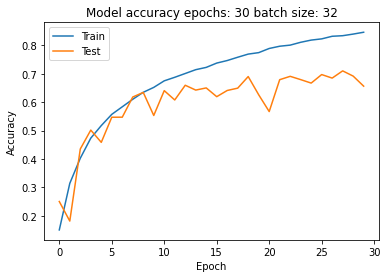

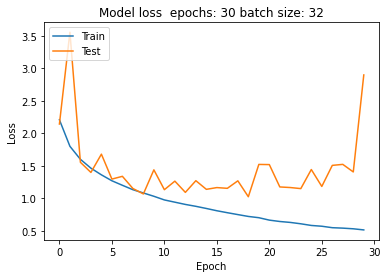

In [17]:
plot_model_history(model_info_v1)

Para ajustar el hiperparametro que pensaliza los pesos de la regularización, realizaremos una pequeña busqueda y seleccionaremos el parametro que entrege la mejor *performance* dentro del set de validación

In [0]:
r_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-6]

In [0]:
model_info_v2 = run_model("inception_cifar10_32_20_6", 10, 20, 32, x_train, y_train, x_validation, y_validation, regularization=r_values[4])

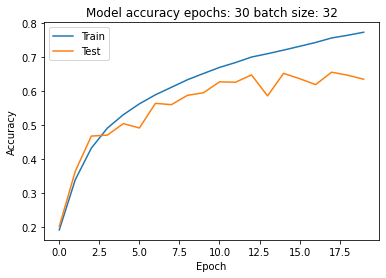

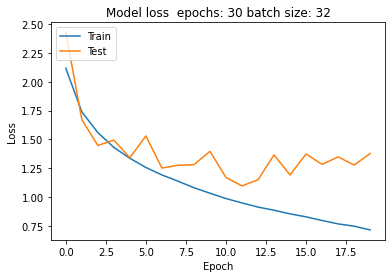

In [32]:
plot_model_history(model_info_v2)

In [0]:
model_info_v4 = run_model("inception_cifar10_32_20_3", 10, 20, 32, x_train, y_train, x_validation, y_validation, regularization=r_values[2], verbose=2)

In [0]:
model_info_v3 =  run_model("inception_cifar10_32_20_2", 10, 20, 32, x_train, y_train, x_validation, y_validation, regularization=r_values[1])

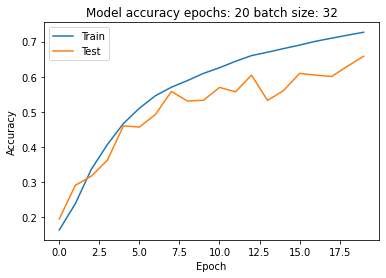

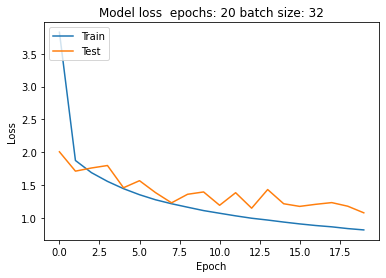

In [18]:
plot_model_history(model_info_v3)

Luego de entrenar los modelos con distintos parametros, graficaremos los resultados para determinar que modelo es mejor.

In [0]:
model_e0 = generate_inception_model("cifar_10_e0")
model_e2 = generate_inception_model("cifar_10_e2", regularization = r_values[1])
model_e3 = generate_inception_model("cifar_10_e3", regularization = r_values[2])
model_e6 = generate_inception_model("cidar_10_e6", regularization = r_values[4])
model_e0.load_weights("drive/My Drive/keras_trainig/10/cp_epochs=30_batch=32.ckpt")
model_e2.load_weights("drive/My Drive/keras_trainig/10/cp_epochs=20_batch=32_0.01.ckpt")
model_e3.load_weights("drive/My Drive/keras_trainig/10/cp_epochs=20_batch=32_0.001.ckpt")
model_e6.load_weights("drive/My Drive/keras_trainig/10/cp_epochs=20_batch=32_1e-06.ckpt")

In [24]:
hyper_parameters = [ 1e-2, 1e-3, 1e-6]
train_acc = [model_e2.evaluate(x_train, y_train),
             model_e3.evaluate(x_train, y_train),
             model_e6.evaluate(x_train, y_train),
             ]
validation_acc = [model_e2.evaluate(x_validation, y_validation),
                  model_e3.evaluate(x_validation, y_validation),
                  model_e6.evaluate(x_validation, y_validation),
                  ]             

5000/5000 [==============================] - 5s 1ms/step


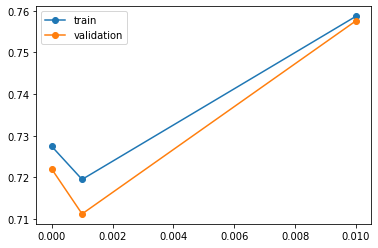

In [25]:
plt.plot(hyper_parameters, list(map(lambda x: x[1], train_acc)), label='train', marker='o')
plt.plot(hyper_parameters, list(map(lambda x: x[1], validation_acc)), label='validation', marker='o')
plt.legend()
plt.show()

En este grafico es claro que una penalización del 0.01 es la que mejor resultados genera dentro del set de validación, Por esta razon ocuparemos este modelo de aqui en adelante

### Actividad 10

Finalmente con el modelo que mejor resultados obtuvo en el set de validación, calculamos el performance en todos los datasets.

In [45]:
print(model_e2.evaluate(x_train, y_train))
print(model_e2.evaluate(x_validation, y_validation))
print(model_e2.evaluate(x_test, y_test))

45000/45000 [==============================] - 41s 915us/step
[0.7170995716094971, 0.7595999836921692]
5000/5000 [==============================] - 5s 909us/step
[0.7365168261528016, 0.7494000196456909]
10000/10000 [==============================] - 9s 913us/step
[1.0687606460571288, 0.659500002861023]


set | valor de función de perdida | acurracy
--- | --- | ---
training | 0.7184019450028737 | 0.7586888670921326
validation | 0.7247955134391785 | 0.7576000094413757
testing | 1.0687606439590454 | 0.659500002861023

Podemos notar que el mejor *accuracy* es en el set de training, es claro que esto se deve a que el modelo se entreno ajustandose a esos datos. Se puede notar tambien que el modelo tiene practicamente el mismo acurracy en el set de validación, esto se puede explicar en parte porque los hiper parametros se escogieron especialmente para mejorar el resultado dentro del set de validación. Finalmente dentro del set de testing se obtuvo un acurracy del 69%, el cual naturalmente es levemente pero resultado que el obtenido en el set de entrenamiento.

In [50]:
from sklearn.metrics import classification_report
import numpy as np

Y_test_idx = np.argmax(y_test, axis=1) # Convert one-hot to index
y_pred = model_e2.predict(x_test)
print(classification_report(Y_test_idx, np.argmax(y_pred,axis=1), target_names=labels_map))

              precision    recall  f1-score   support

    airplane       0.81      0.65      0.72      1000
  automobile       0.85      0.74      0.80      1000
        bird       0.60      0.52      0.56      1000
         cat       0.40      0.49      0.44      1000
        deer       0.59      0.59      0.59      1000
         dog       0.50      0.58      0.54      1000
        frog       0.70      0.70      0.70      1000
       horse       0.70      0.72      0.71      1000
        ship       0.80      0.85      0.82      1000
       truck       0.75      0.75      0.75      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000



In [0]:
def get_wrong_classifications(x_test, y_predicted, y_test, target_label, n):
    result = []
    for idx in range(len(x_test)):
      if y_predicted[idx] != y_test[idx] and y_test[idx] == target_label:
        n -= 1
        result.append((x_test[idx], y_predicted[idx]))
        if n == 0:
          return result
    return result      

Finalmente en la tabla anterior se puede notar que el pero rendimiento del modelo ocurre con la clase *Cat* con un score f1 de 44%. Para entender con mas detalle este error, podemos revisar algunas imagenes en donde clasifica mal a los gatos.

In [0]:
wrong_img = get_wrong_classifications(x_test,  np.argmax(y_pred,axis=1), Y_test_idx, 3, 12)

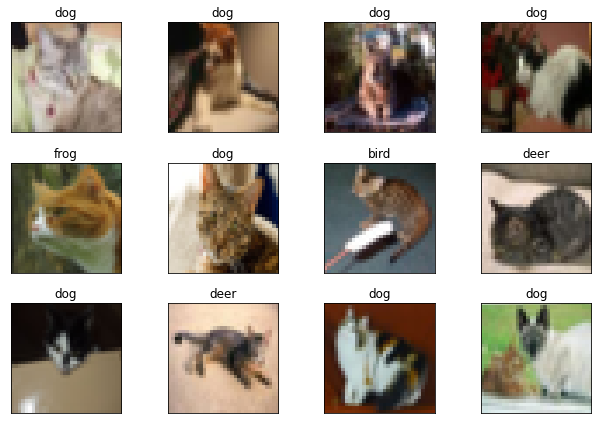

In [55]:
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, sample_index in zip(axs.flat, list(range(18))):
    ax.imshow(wrong_img[sample_index][0], interpolation='none')
    ax.set_title(labels_map[wrong_img[sample_index][1]])

plt.tight_layout()
plt.show()

Las etiquetas que estan sobre las imagenes representan la predicción otorga por el modelo. En su mayoria el modelo esta confundiendo los gatos con perros y venados. lo cual tiene sentido porque ambos son animales y mamiferos, por tanto comparten alguna **feutures similares**. 

## Parte 2.2: Comparación según set de datos

### Actividad 11


CIFAR100 corresponde a un dataset de imagenes de 32x32x3 al igual que CIFAR10, con la unica diferencia que CIFAR100 tiene 100 posibles labels distintas. Por tanto usaremos la misma division que en CIFAR10:

set | cantidad de instancias | porcentaje relativo del total
--- | --- | --- |
train | 45000 | 75%
validation (hyperparameters tunning)| 5000 | 8,3333%
test |  10000 | 16,6666%


Las clases de las labels tiene el siguiente mapeo:

In [0]:
CIFAR100_map = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

In [11]:
from keras.datasets import cifar100

(x_train_100, y_train_100), (x_test_100, y_test_100) = cifar100.load_data()
print(x_train_100.shape)
print(x_test_100.shape)

169009152/169001437 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


A continuación se muestran imagenes del dataset y sus respectivas etiquetas.

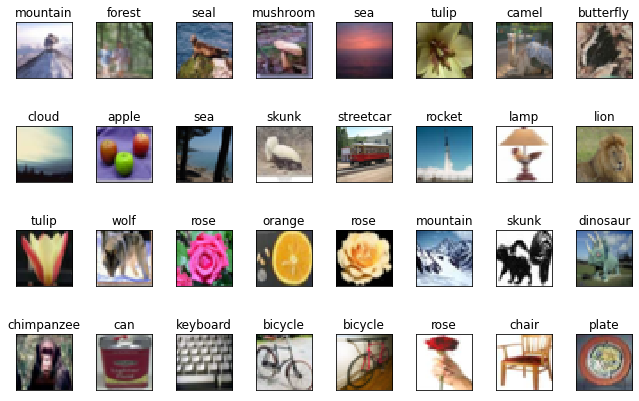

In [41]:
fig, axs = plt.subplots(nrows=4, ncols=8, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for ax, sample_index in zip(axs.flat, list(range(32))):
    ax.imshow(x_test_100[sample_index], interpolation='none')
    ax.set_title(CIFAR100_map[y_test_100[sample_index][0]])

plt.tight_layout()
plt.show()

Luego creamos la division del validation set tomando un 10% del training set

In [12]:
from sklearn.model_selection import train_test_split

# Convert class vectors to binary class matrices.
y_train_100 = keras.utils.to_categorical(y_train_100, 100)
y_test_100 = keras.utils.to_categorical(y_test_100, 100)

#split a validation set from the training set
x_train_100, x_validation_100, y_train_100, y_validation_100 = train_test_split(x_train_100, y_train_100, test_size=0.1)
print("Train set shape:", x_train_100.shape)
print("Validation set shape", x_validation_100.shape)

Train set shape: (45000, 32, 32, 3)
Validation set shape (5000, 32, 32, 3)


Finalmente para adaptar el modelo a CIFAR100 simplemente cambiamos la ultima capa desde una capa densa con un output de 10 neuronas a una capa densa con un output de 100 neuronas (una neurona por cada clase). Esto lo podemos hacer simplemente cambiando el segundo parametro de la funcion run_model de la Actividad 9. 

Este Adaptación se puede hacer con facilidad devido a que la entrada del input es de el mismo tamaño que el de CIFAR10, por tanto no es necesario adapatar las capas previas a la ultima.

In [14]:
model_100_info_v1 = run_model("inception_100_1", 100, 30, 32, x_train_100,
                              y_train_100, x_validation_100, y_validation_100, 
                              regularization = 0, verbose=1) 

training model with 30 epochs and 32 batch size
Train on 45000 samples, validate on 5000 samples
Epoch 1/30
45000/45000 [==============================] - 410s 9ms/step - loss: 4.4953 - accuracy: 0.0187 - val_loss: 4.3096 - val_accuracy: 0.0336
Epoch 2/30
45000/45000 [==============================] - 405s 9ms/step - loss: 4.1781 - accuracy: 0.0429 - val_loss: 4.3015 - val_accuracy: 0.0426
Epoch 3/30
45000/45000 [==============================] - 411s 9ms/step - loss: 3.9908 - accuracy: 0.0698 - val_loss: 4.3337 - val_accuracy: 0.0580
Epoch 4/30
45000/45000 [==============================] - 407s 9ms/step - loss: 3.8186 - accuracy: 0.0994 - val_loss: 4.2347 - val_accuracy: 0.0786
Epoch 5/30
45000/45000 [==============================] - 414s 9ms/step - loss: 3.6858 - accuracy: 0.1230 - val_loss: 3.7778 - val_accuracy: 0.1212
Epoch 6/30
45000/45000 [==============================] - 411s 9ms/step - loss: 3.5794 - accuracy: 0.1440 - val_loss: 3.8849 - val_accuracy: 0.1210
Epoch 7/30
4500

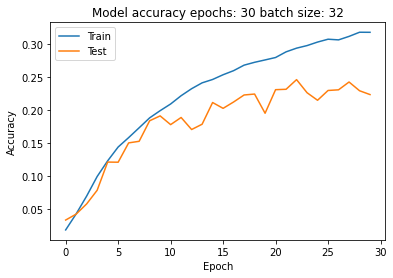

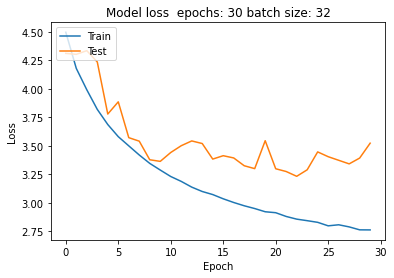

In [18]:
plot_model_history(model_100_info_v1)

En los graficos se puede apreciar un comportamiento muy parecido al de cifar-10 sin regularización. En donde la perdida y el acurracy van mejorando el **performance** de manera muy "estable", mientras que el performance dentro del set test, va mejorando pero con una gran variación. Claramente existe una diferecia en el performance, ya que se necesitan mas datos para poder entrenar mas feutures que permitan generar un mejor clasificador. La tarea de este clasificador, es bastante mas dificil, ya que por ejemplo si el clasificar de cifar10 elije imagenes de manera aleatoria, automaticamente tendria un acurracy del 10% mientras que si el modelo de CIFAR100 escoje de manera aleatoria tendria un acurracy del 1%

### Actividad 12


In [0]:
model_100_e0 = generate_inception_model("cifar_100_e0", labels=100)
model_100_e0.load_weights("drive/My Drive/keras_trainig/100/cp_epochs=30_batch=32_0.ckpt")

In [24]:
print(model_100_e0.evaluate(x_train_100, y_train_100))
print(model_100_e0.evaluate(x_validation_100, y_validation_100))
print(model_100_e0.evaluate(x_test_100, y_test_100))

45000/45000 [==============================] - 39s 858us/step
[2.845370278422038, 0.3107333481311798]
5000/5000 [==============================] - 4s 858us/step
[3.5221008193969725, 0.2231999933719635]
10000/10000 [==============================] - 9s 913us/step
[3.422574156188965, 0.23420000076293945]


set | valor de función de perdida | acurracy
--- | --- | ---
training | 0.7184019450028737 | 0.3107333481311798
validation | 0.7247955134391785 | 0.2231999933719635
testing | 1.0687606439590454 | 0.23420000076293945

Finalmente, luego de 30 epocas y batch de 32, el modelo alcanzo un acurracy de 23,4% en el set de testing (nunca visto ni usado para tunning). En este caso como no se uso regularisación ni ajuste de hiperparametros el acurracy en el set de validación y en el set de testing es muy parecido, mientras que el acurracy en el set de training es al rededor de 9% superior.

A continuación revisaremos en detalle, que clases afectaron mas al performance del modelo.

In [57]:
from sklearn.metrics import classification_report
import numpy as np

Y_test_100_idx = np.argmax(y_test_100, axis=1) # Convert one-hot to index
y_pred_100 = model_100_e0.predict(x_test_100)
print(classification_report(Y_test_100_idx, np.argmax(y_pred_100,axis=1), target_names=CIFAR100_map))

               precision    recall  f1-score   support

        apple       0.61      0.48      0.54       100
aquarium_fish       0.30      0.27      0.29       100
         baby       0.29      0.17      0.22       100
         bear       0.20      0.04      0.07       100
       beaver       0.07      0.08      0.08       100
          bed       0.12      0.31      0.17       100
          bee       0.22      0.08      0.12       100
       beetle       0.53      0.10      0.17       100
      bicycle       0.14      0.23      0.17       100
       bottle       0.39      0.26      0.31       100
         bowl       0.11      0.06      0.08       100
          boy       0.28      0.11      0.16       100
       bridge       0.33      0.07      0.12       100
          bus       0.21      0.13      0.16       100
    butterfly       0.10      0.14      0.12       100
        camel       0.08      0.21      0.12       100
          can       0.24      0.32      0.27       100
       ca

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Con la tabla podemos notar que existen varias clases que tiene un rendimiento bastante menor al promedio, sin embargo existen un grupo que tiene un Precision and recall de 0. lo cual perjudica bastante el modelo. estas clases son:

1.   Otter (55)      
2.   Rose (70)     
3.   Seal (72)       

A continuacoón podemos revisar porque se equivoca tan rotundamente con estas clases


In [0]:
wrong_img_100_70 = get_wrong_classifications(x_test_100,  np.argmax(y_pred_100,axis=1), Y_test_100_idx, 70, 8)
wrong_img_100_72 = get_wrong_classifications(x_test_100,  np.argmax(y_pred_100,axis=1), Y_test_100_idx, 72, 8)
wrong_img_100_55 = get_wrong_classifications(x_test_100,  np.argmax(y_pred_100,axis=1), Y_test_100_idx, 55, 8)

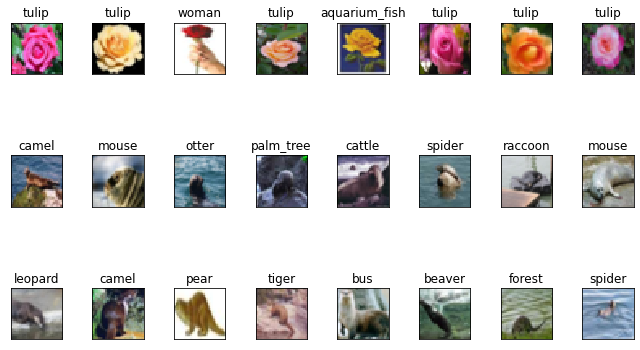

In [72]:
fig, axs = plt.subplots(nrows=3, ncols=8, figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for wrong_images, idx in zip([wrong_img_100_70, wrong_img_100_72, wrong_img_100_55], list(range(3))):
    for ax, sample_index in zip(axs.flat[8*idx: 8*idx + 8], list(range(8))):
      ax.imshow(wrong_images[sample_index][0], interpolation='none')
      ax.set_title(CIFAR100_map[wrong_images[sample_index][1]])

plt.tight_layout()
plt.show()

En la primera fila, podemos ver como el modelo esta confundiendo las rosas con los tulipanes, esto tiene bastante sentido ya que ambas son flores.

Luego en la segunda fila tenemos imagenes de focas. Podemos notar que la calidad de las imagenes, es tan mala que incliso a un humamo le costaria distinguir bien que es una foca.

Finalmente en la ultima fila podemos ver imagenes de nutrias, y como sucede algo parecido a lo que sucede con las focas. Es interesante que estas dos ultimas clases comparten feutures parecidas, una hipotesos, es que los filtros no alcanzaron a crear feutires para este tipo de animal.

### Actividad 13

In [68]:
print("cifar 10")
print(model_e0.evaluate(x_train, y_train))
print(model_e0.evaluate(x_validation, y_validation))
print(model_e0.evaluate(x_test, y_test))
print("cifar100")
print(model_100_e0.evaluate(x_train_100, y_train_100))
print(model_100_e0.evaluate(x_validation_100, y_validation_100))
print(model_100_e0.evaluate(x_test_100, y_test_100))

cifar 10
45000/45000 [==============================] - 40s 884us/step
[1.0798247196144528, 0.7828222513198853]
5000/5000 [==============================] - 5s 1ms/step
[1.0834620789527893, 0.7883999943733215]
10000/10000 [==============================] - 10s 1ms/step
[3.043802466964722, 0.6449999809265137]
cifar100
45000/45000 [==============================] - 37s 824us/step
[2.845370278422038, 0.3107333481311798]
5000/5000 [==============================] - 5s 910us/step
[3.5221008193969725, 0.2231999933719635]
10000/10000 [==============================] - 9s 875us/step
[3.422574156188965, 0.23420000076293945]


set | cantidad de instancias | porcentaje relativo del total | Acurracy CIFAR10 | Acurracy CIFAR10 |
--- | --- | --- | --- | --- |
train | 45000 | 75% |  78,28% | 31,07%
validation (hyperparameters tunning)| 5000 | 8,3333% |  78,83% | 22,31%
test |  10000 | 16,6666% | 64,49% | 23,42%

Como conclusión final podemos ver que Google net tiene un accuraccy del 64,49% cuando tiene la tarea de clasificar 10 etiquetas de imagenes y un accurracy de 23,42% cuando tiene que clasificar 100 etiquetas. En mi opinión, a pesar de que el acurracy haya disminuido al 22% cuando se aumentar las etiquetas, GoogleNet es un modelo bastante robusto, ya que la tarea se complico 10 veces mas, pero las representaciones de feutures permite que el acurracy disminuya a un tercio y no a un decimo del puntaje original.